<div style="float: left">
  <img src='https://www.tu-clausthal.de/fileadmin/TU_Clausthal/images/CorporateDesign/Logo/Logo_TUC_de_Web.gif'>
</div>
<div style="float: right; font-size: 0.8em">
  <div style="margin-bottom: 0.8em">
    <span style="font-weight: bold; font-size: 1.2em;">Institut für Mathematik</span><br />
  </div>
    <div>
        Prof. Dr. Andreas Potschka<br />
        Kaisar Dawara
    </div>
  </div>
</div>

# TUC Drillbotics Trajectory Optimization Tool

## Abstract

The TUC Drillbotics team participates in the international Drillbotics competition, where the drilling trajectory must be planned through a set of goal points that are not aligned in a straight line. The planned trajectory will be executed by an autonomous miniature drilling rig. Constraints on the trajectory are imposed by the physical properties of the Bottom Hole Assembly (BHA).

---

## Introduction

In the context of the Drillbotics competition, a key challenge lies in the automated generation of drillable trajectories through a predefined set of 3D coordinates, all under mechanical and physical constraints. To facilitate the development and comparison of various trajectory planning algorithms, a systematic evaluation framework is required.

The goal of this project is to design and implement a **trajectory optimization and evaluation tool** that quantitatively assesses the output of different planning approaches.

---

## Task Description

The task is to program a tool that evaluates generated trajectories. The tool should accept either a **discrete** (sequence of waypoints) or **continuous** (parametric curve) representation of a trajectory and compute a **composite cost function** based on multiple, weighted evaluation criteria.

### Evaluation Criteria

The evaluation tool will compute a cost based on the following (customizable) metrics:

* **Total Path Length**
    Affects drilling time and material wear.

* **Cumulative Angular Deviation / Curvature**
    Penalizes sharp bends and infeasible transitions. Encourages smoother trajectories and discourages zigzag paths, even if each individual bend is mechanically feasible.

* **Mechanical Feasibility Constraints**
    Includes constraints such as maximum allowable deviation per segment and minimum radius of curvature.

* **Estimated Energy Consumption and Time**
    Based on the geometry of the path and expected drilling dynamics.

### Features

* Composite cost function for multi-objective evaluation.
* Support for sensitivity analysis (adjustable weights).
* Comparison and ranking of different trajectory planning algorithms.
* Modular design to allow future extensions.

### Purpose

The scalar cost produced by the tool provides a **quantitative and objective basis** for:

* Comparing and ranking trajectory planning algorithms.
* Supporting iterative algorithm optimization.
* Encouraging multi-objective optimization in planning strategies.
---

In [1]:
# importaions
from rockit import *
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ocp = Ocp()
target0 = [0, 0, 0]
target1 = [2.5, 2.5, -10]  # Slightly offset
target2 = [5, 5, -40]

In [3]:
# ---------------------------------
#           STAGE 1
# ---------------------------------
stage1 = ocp.stage(T=FreeTime(10))

# States
x_pos1 = stage1.state()
y_pos1 = stage1.state()
z_pos1 = stage1.state()
t1 = stage1.state()
azimuth1 = stage1.state()
inclination1 = stage1.state()

# Controls
u_azimuth_rate_ds1 = stage1.control()
u_inclination_rate_ds1 = stage1.control()
inverse_rop1 = stage1.control()

# Dynamics (with respect to arc length 's')
v_x_ds1 = ca.sin(inclination1) * ca.cos(azimuth1)
v_y_ds1 = ca.sin(inclination1) * ca.sin(azimuth1)
v_z_ds1 = ca.cos(inclination1)

stage1.set_der(x_pos1, v_x_ds1)
stage1.set_der(y_pos1, v_y_ds1)
stage1.set_der(z_pos1, v_z_ds1)
stage1.set_der(azimuth1, u_azimuth_rate_ds1)
stage1.set_der(inclination1, u_inclination_rate_ds1)
stage1.set_der(t1, inverse_rop1)

# Objective
stage1.add_objective(stage1.integral(inverse_rop1))

# Initial Conditions for Stage 1
ocp.subject_to(stage1.t0 == 0)
stage1.subject_to(stage1.at_t0(x_pos1) == target0[0])
stage1.subject_to(stage1.at_t0(y_pos1) == target0[1])
stage1.subject_to(stage1.at_t0(z_pos1) == target0[2])
stage1.subject_to(stage1.at_t0(azimuth1) == 0)
stage1.subject_to(stage1.at_t0(inclination1) == ca.pi) # Pointing straight down
stage1.subject_to(stage1.at_t0(t1) == 0)

# Final Conditions for Stage 1
stage1.subject_to(stage1.at_tf(x_pos1) == target1[0])
stage1.subject_to(stage1.at_tf(y_pos1) == target1[1])
stage1.subject_to(stage1.at_tf(z_pos1) == target1[2])

# Path Constraints for Stage 1
max_bur = 0.05
stage1.subject_to(inclination1 >= ca.pi/2)
stage1.subject_to(inclination1 <= 3*ca.pi/2)

stage1.subject_to(u_inclination_rate_ds1 >= -max_bur)
stage1.subject_to(u_inclination_rate_ds1 <=  max_bur)
stage1.subject_to(u_azimuth_rate_ds1 >= -max_bur)
stage1.subject_to(u_azimuth_rate_ds1 <=  max_bur)

rop_max = 30
rop_min = 5
stage1.subject_to(inverse_rop1 >= 1/rop_max)
stage1.subject_to(inverse_rop1 <= 1/rop_min)

stage1.method(DirectCollocation(N=10))

In [4]:

# ---------------------------------
#           STAGE 2
# ---------------------------------
stage2 = ocp.stage(T=FreeTime(10))

# States for Stage 2
x_pos2 = stage2.state()
y_pos2 = stage2.state()
z_pos2 = stage2.state()
t2 = stage2.state()
azimuth2 = stage2.state()
inclination2 = stage2.state()

# Controls for Stage 2
u_azimuth_rate_ds2 = stage2.control()
u_inclination_rate_ds2 = stage2.control()
inverse_rop2 = stage2.control()

# Dynamics for Stage 2
v_x_ds2 = ca.sin(inclination2) * ca.cos(azimuth2)
v_y_ds2 = ca.sin(inclination2) * ca.sin(azimuth2)
v_z_ds2 = ca.cos(inclination2)

stage2.set_der(x_pos2, v_x_ds2)
stage2.set_der(y_pos2, v_y_ds2)
stage2.set_der(z_pos2, v_z_ds2)
stage2.set_der(azimuth2, u_azimuth_rate_ds2)
stage2.set_der(inclination2, u_inclination_rate_ds2)
stage2.set_der(t2, inverse_rop2)

# Objective for Stage 2
stage2.add_objective(stage2.integral(inverse_rop2))

# LINKING STAGES: Initial conditions for Stage 2 === Final conditions for Stage 1
ocp.subject_to(stage2.t0 == stage1.tf)
ocp.subject_to(stage2.at_t0(x_pos2) == stage1.at_tf(x_pos1))
ocp.subject_to(stage2.at_t0(y_pos2) == stage1.at_tf(y_pos1))
ocp.subject_to(stage2.at_t0(z_pos2) == stage1.at_tf(z_pos1))
ocp.subject_to(stage2.at_t0(azimuth2) == stage1.at_tf(azimuth1))
ocp.subject_to(stage2.at_t0(inclination2) == stage1.at_tf(inclination1))
ocp.subject_to(stage2.at_t0(t2) == stage1.at_tf(t1))

# Final Conditions for Stage 2
stage2.subject_to(stage2.at_tf(x_pos2) == target2[0])
stage2.subject_to(stage2.at_tf(y_pos2) == target2[1])
stage2.subject_to(stage2.at_tf(z_pos2) == target2[2])

# Path Constraints for Stage 2
stage2.subject_to(u_inclination_rate_ds2 >= -max_bur)
stage2.subject_to(u_inclination_rate_ds2 <=  max_bur)
stage2.subject_to(u_azimuth_rate_ds2 >= -max_bur)
stage2.subject_to(u_azimuth_rate_ds2 <=  max_bur)

stage2.subject_to(inclination2 >= ca.pi/2)
stage2.subject_to(inclination2 <= 3*ca.pi/2)
stage2.subject_to(inverse_rop2 >= 1/rop_max)
stage2.subject_to(inverse_rop2 <= 1/rop_min)

stage2.method(DirectCollocation(N=10))

In [5]:
# Solve the OCP

ocp.solver('ipopt')
sol = ocp.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     4265
Number of nonzeros in inequality constraint Jacobian.:      178
Number of nonzeros in Lagrangian Hessian.............:      862

Total number of variables............................:      674
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      619
Total number of inequality c

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:217:
.../casadi/core/optistack_internal.cpp:1334: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     8504
Number of nonzeros in inequality constraint Jacobian.:      338
Number of nonzeros in Lagrangian Hessian.............:     1682

Total number of variables............................:     1334
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1218
Total number of inequality constraints...............:      338
        inequality constraints with only lower bounds:      170
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      168

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+01 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

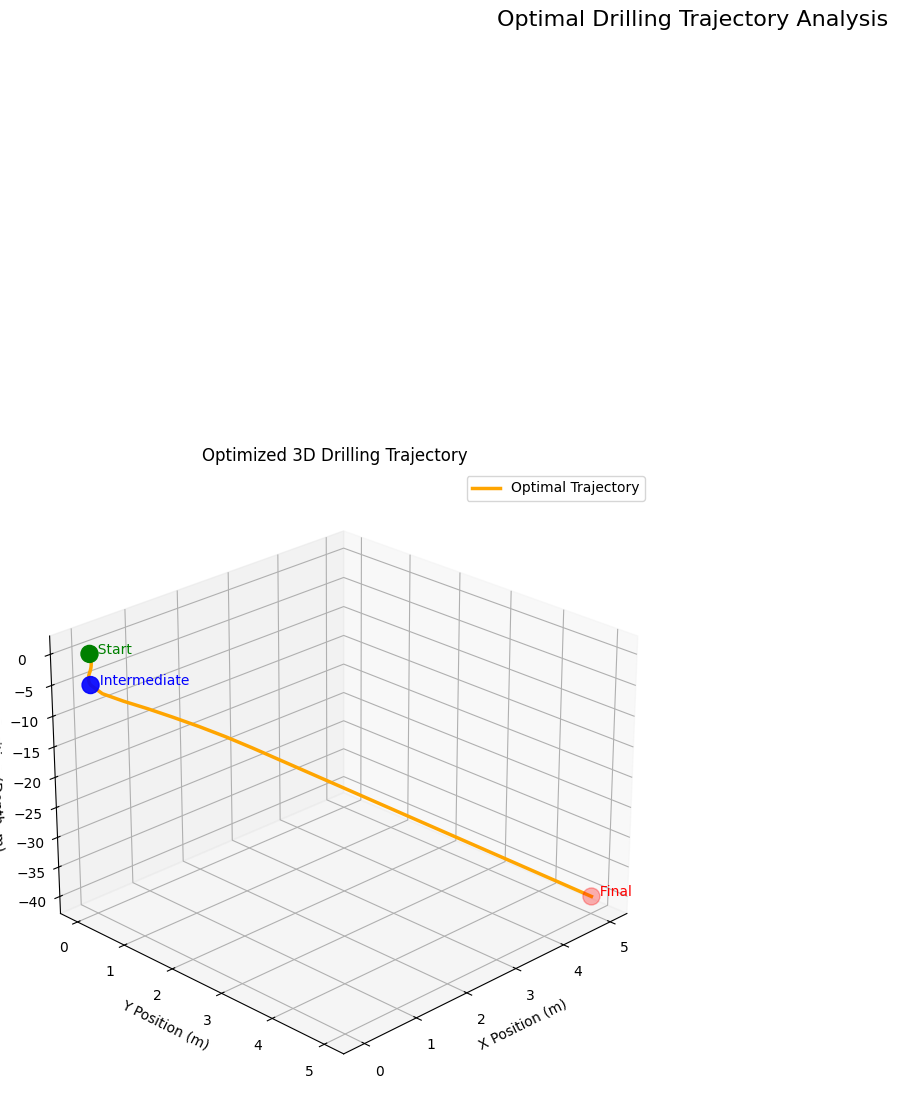

In [7]:
# Optimal Drilling Trajectory for TUC Drillbotics
# This script uses the rockit library to find the optimal trajectory for a drill bit
# passing through three points (start, intermediate, final).
# The problem is modeled as a two-stage Optimal Control Problem (OCP) where
# the objective is to minimize the total drilling time.
# The system dynamics are parameterized by arc length 's', as detailed in the
# provided "Trajectory.pdf" and "project.ipynb" documents.

import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from rockit import Ocp, FreeTime, DirectCollocation

def create_drilling_stage(ocp):
    """
    Creates a single stage of the drilling trajectory OCP.

    This function defines the common states, controls, dynamics, and path constraints
    for any segment of the trajectory.

    Parameters
    ----------
    ocp : rockit.Ocp
        The Optimal Control Problem object.

    Returns
    -------
    stage : rockit.Stage
        The configured OCP stage.
    x_pos, y_pos, z_pos, t, azimuth, inclination : casadi.MX
        State variables.
    u_azimuth_rate_ds, u_inclination_rate_ds, inverse_rop : casadi.MX
        Control variables.
    """
    # Create a stage with a free independent variable (arc length 's')
    # An initial guess of 10 for the arc length is provided.
    stage = ocp.stage(T=FreeTime(10.0))

    # --- State Variables ---
    # Position
    x_pos = stage.state()
    y_pos = stage.state()
    z_pos = stage.state()
    # Time
    t = stage.state()
    # Angles
    azimuth = stage.state()
    inclination = stage.state()

    # --- Control Variables ---
    # Angular rates with respect to arc length 's'
    u_azimuth_rate_ds = stage.control()     # dA/ds
    u_inclination_rate_ds = stage.control() # dI/ds
    # Inverse of Rate of Penetration (ROP)
    inverse_rop = stage.control()           # dt/ds

    # --- System Dynamics (derivatives w.r.t. arc length 's') ---
    stage.set_der(x_pos, ca.sin(inclination) * ca.cos(azimuth))
    stage.set_der(y_pos, ca.sin(inclination) * ca.sin(azimuth))
    stage.set_der(z_pos, ca.cos(inclination))
    stage.set_der(azimuth, u_azimuth_rate_ds)
    stage.set_der(inclination, u_inclination_rate_ds)
    stage.set_der(t, inverse_rop)

    # --- Path Constraints ---
    # Maximum Build-Up Rate (BUR) in rad/m
    max_bur = 0.05
    stage.subject_to(u_inclination_rate_ds >= -max_bur)
    stage.subject_to(u_inclination_rate_ds <= max_bur)
    stage.subject_to(u_azimuth_rate_ds >= -max_bur)
    stage.subject_to(u_azimuth_rate_ds <= max_bur)

    # Constraint to ensure the drill bit always points downwards
    # Inclination must be between 90 (pi/2) and 270 (3*pi/2) degrees.
    stage.subject_to(inclination >= ca.pi / 2)
    stage.subject_to(inclination <= 3 * ca.pi / 2)

    # Rate of Penetration (ROP) limits in m/min
    rop_max = 30.0
    rop_min = 5.0
    # Constraints are on the inverse of ROP (dt/ds)
    stage.subject_to(inverse_rop >= 1 / rop_max)
    stage.subject_to(inverse_rop <= 1 / rop_min)

    # --- Discretization Method ---
    # Using Direct Collocation with 40 nodes for higher accuracy.
    stage.method(DirectCollocation(N=20))

    return (stage, x_pos, y_pos, z_pos, t, azimuth, inclination,
            u_azimuth_rate_ds, u_inclination_rate_ds, inverse_rop)

# -------------------------------------------------------------------------
# --- Main Problem Setup ---
# -------------------------------------------------------------------------

# Initialize the Optimal Control Problem
ocp = Ocp()

# Define the target points for the trajectory
start_point = [0, 0, 0]
intermediate_point = [0, 0, -5]
final_point = [5, 5, -40]

# --- Stage 1: Start Point to Intermediate Point ---
(s1, x1, y1, z1, t1, a1, i1, ua1, ui1, ir1) = create_drilling_stage(ocp)

# Set initial conditions for the entire trajectory (at t0 of stage 1)
ocp.subject_to(s1.at_t0(x1) == start_point[0])
ocp.subject_to(s1.at_t0(y1) == start_point[1])
ocp.subject_to(s1.at_t0(z1) == start_point[2])
ocp.subject_to(s1.at_t0(a1) == 0)        # Azimuth starts at 0
ocp.subject_to(s1.at_t0(i1) == ca.pi)    # Inclination is pi (pointing down)
ocp.subject_to(s1.at_t0(t1) == 0)        # Time starts at 0

# Set terminal conditions for stage 1 (the intermediate point)
ocp.subject_to(s1.at_tf(x1) == intermediate_point[0])
ocp.subject_to(s1.at_tf(y1) == intermediate_point[1])
ocp.subject_to(s1.at_tf(z1) == intermediate_point[2])


# --- Stage 2: Intermediate Point to Final Point ---
(s2, x2, y2, z2, t2, a2, i2, ua2, ui2, ir2) = create_drilling_stage(ocp)

# Impose continuity between Stage 1 and Stage 2
# The final state of stage 1 must equal the initial state of stage 2.
ocp.subject_to(s1.at_tf(x1) == s2.at_t0(x2))
ocp.subject_to(s1.at_tf(y1) == s2.at_t0(y2))
ocp.subject_to(s1.at_tf(z1) == s2.at_t0(z2))
ocp.subject_to(s1.at_tf(t1) == s2.at_t0(t2))
ocp.subject_to(s1.at_tf(a1) == s2.at_t0(a2))
ocp.subject_to(s1.at_tf(i1) == s2.at_t0(i2))

# Set terminal conditions for stage 2 (the final point)
ocp.subject_to(s2.at_tf(x2) == final_point[0])
ocp.subject_to(s2.at_tf(y2) == final_point[1])
ocp.subject_to(s2.at_tf(z2) == final_point[2])

# --- Objective Function ---
# Minimize the total time, which is the value of state 't' at the end of stage 2.
# This is a terminal (Mayer) cost, added to the final stage.
s2.add_objective(s2.at_tf(t2))

# --- Solve the OCP ---
ocp.solver('ipopt')
sol = ocp.solve()

# -------------------------------------------------------------------------
# --- Plotting Results ---
# -------------------------------------------------------------------------

# --- Sample data from both stages ---
# Get the final arc length of stage 1 to offset the second stage's results
s1_tf_val = sol(s1).value(s1.tf)

# Stage 1 data
ts1, x1_sol = sol(s1).sample(x1, grid='integrator')
ts1, y1_sol = sol(s1).sample(y1, grid='integrator')
ts1, z1_sol = sol(s1).sample(z1, grid='integrator')
ts1, t1_sol = sol(s1).sample(t1, grid='integrator')
ts1, a1_sol = sol(s1).sample(a1, grid='integrator')
ts1, i1_sol = sol(s1).sample(i1, grid='integrator')
ts1_ctrl, ua1_sol = sol(s1).sample(ua1, grid='control')
ts1_ctrl, ui1_sol = sol(s1).sample(ui1, grid='control')
ts1_ctrl, ir1_sol = sol(s1).sample(ir1, grid='control')

# Stage 2 data
ts2, x2_sol = sol(s2).sample(x2, grid='integrator')
ts2, y2_sol = sol(s2).sample(y2, grid='integrator')
ts2, z2_sol = sol(s2).sample(z2, grid='integrator')
ts2, t2_sol = sol(s2).sample(t2, grid='integrator')
ts2, a2_sol = sol(s2).sample(a2, grid='integrator')
ts2, i2_sol = sol(s2).sample(i2, grid='integrator')
ts2_ctrl, ua2_sol = sol(s2).sample(ua2, grid='control')
ts2_ctrl, ui2_sol = sol(s2).sample(ui2, grid='control')
ts2_ctrl, ir2_sol = sol(s2).sample(ir2, grid='control')


# --- Combine data for continuous plots ---
s_sol = np.concatenate((ts1, ts2 + s1_tf_val))
x_sol = np.concatenate((x1_sol, x2_sol))
y_sol = np.concatenate((y1_sol, y2_sol))
z_sol = np.concatenate((z1_sol, z2_sol))
t_sol = np.concatenate((t1_sol, t2_sol))
a_sol = np.concatenate((a1_sol, a2_sol))
i_sol = np.concatenate((i1_sol, i2_sol))

s_ctrl_sol = np.concatenate((ts1_ctrl, ts2_ctrl + s1_tf_val))
ua_sol = np.concatenate((ua1_sol, ua2_sol))
ui_sol = np.concatenate((ui1_sol, ui2_sol))
ir_sol = np.concatenate((ir1_sol, ir2_sol))

# --- Create Plots ---
fig = plt.figure(figsize=(18, 16))
fig.suptitle('Optimal Drilling Trajectory Analysis', fontsize=16)

# 3D Trajectory Plot
ax3d = fig.add_subplot(2, 2, (1, 3), projection='3d')
ax3d.plot(x_sol, y_sol, z_sol, label='Optimal Trajectory', linewidth=2.5, color='orange')
points = np.array([start_point, intermediate_point, final_point])
ax3d.scatter(points[:,0], points[:,1], points[:,2], c=['green', 'blue', 'red'], s=150, depthshade=True)
ax3d.text(points[0,0], points[0,1], points[0,2], '  Start', color='green')
ax3d.text(points[1,0], points[1,1], points[1,2], '  Intermediate', color='blue')
ax3d.text(points[2,0], points[2,1], points[2,2], '  Final', color='red')
ax3d.set_xlabel("X Position (m)")
ax3d.set_ylabel("Y Position (m)")
ax3d.set_zlabel("Z Position (Depth, m)")
ax3d.set_title("Optimized 3D Drilling Trajectory")
ax3d.legend()
ax3d.invert_yaxis() # Invert Z-axis to show depth correctly
ax3d.view_init(elev=25, azim=-135)

# # Position vs. Arc Length
# ax1 = fig.add_subplot(2, 2, 2)
# ax1.plot(s_sol, x_sol, label='x_pos')
# ax1.plot(s_sol, y_sol, label='y_pos')
# ax1.plot(s_sol, z_sol, label='z_pos')
# ax1.set_title("Position Components vs. Arc Length")
# ax1.set_xlabel("Arc Length (s)")
# ax1.set_ylabel("Position (m)")
# ax1.legend()
# ax1.grid(True)

# # Angles vs. Arc Length
# ax2 = fig.add_subplot(2, 2, 4)
# ax2.plot(s_sol, np.rad2deg(a_sol), label='Azimuth')
# ax2.plot(s_sol, np.rad2deg(i_sol), label='Inclination')
# ax2.set_title("Angles vs. Arc Length")
# ax2.set_xlabel("Arc Length (s)")
# ax2.set_ylabel("Angle (degrees)")
# ax2.legend()
# ax2.grid(True)

# plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    16984
Number of nonzeros in inequality constraint Jacobian.:      658
Number of nonzeros in Lagrangian Hessian.............:     3682

Total number of variables............................:     2654
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2418
Total number of inequality constraints...............:      658
        inequality constraints with only lower bounds:      330
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      328

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+01 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Text(0.5, 1.0, 'Angles vs. Arc Length')

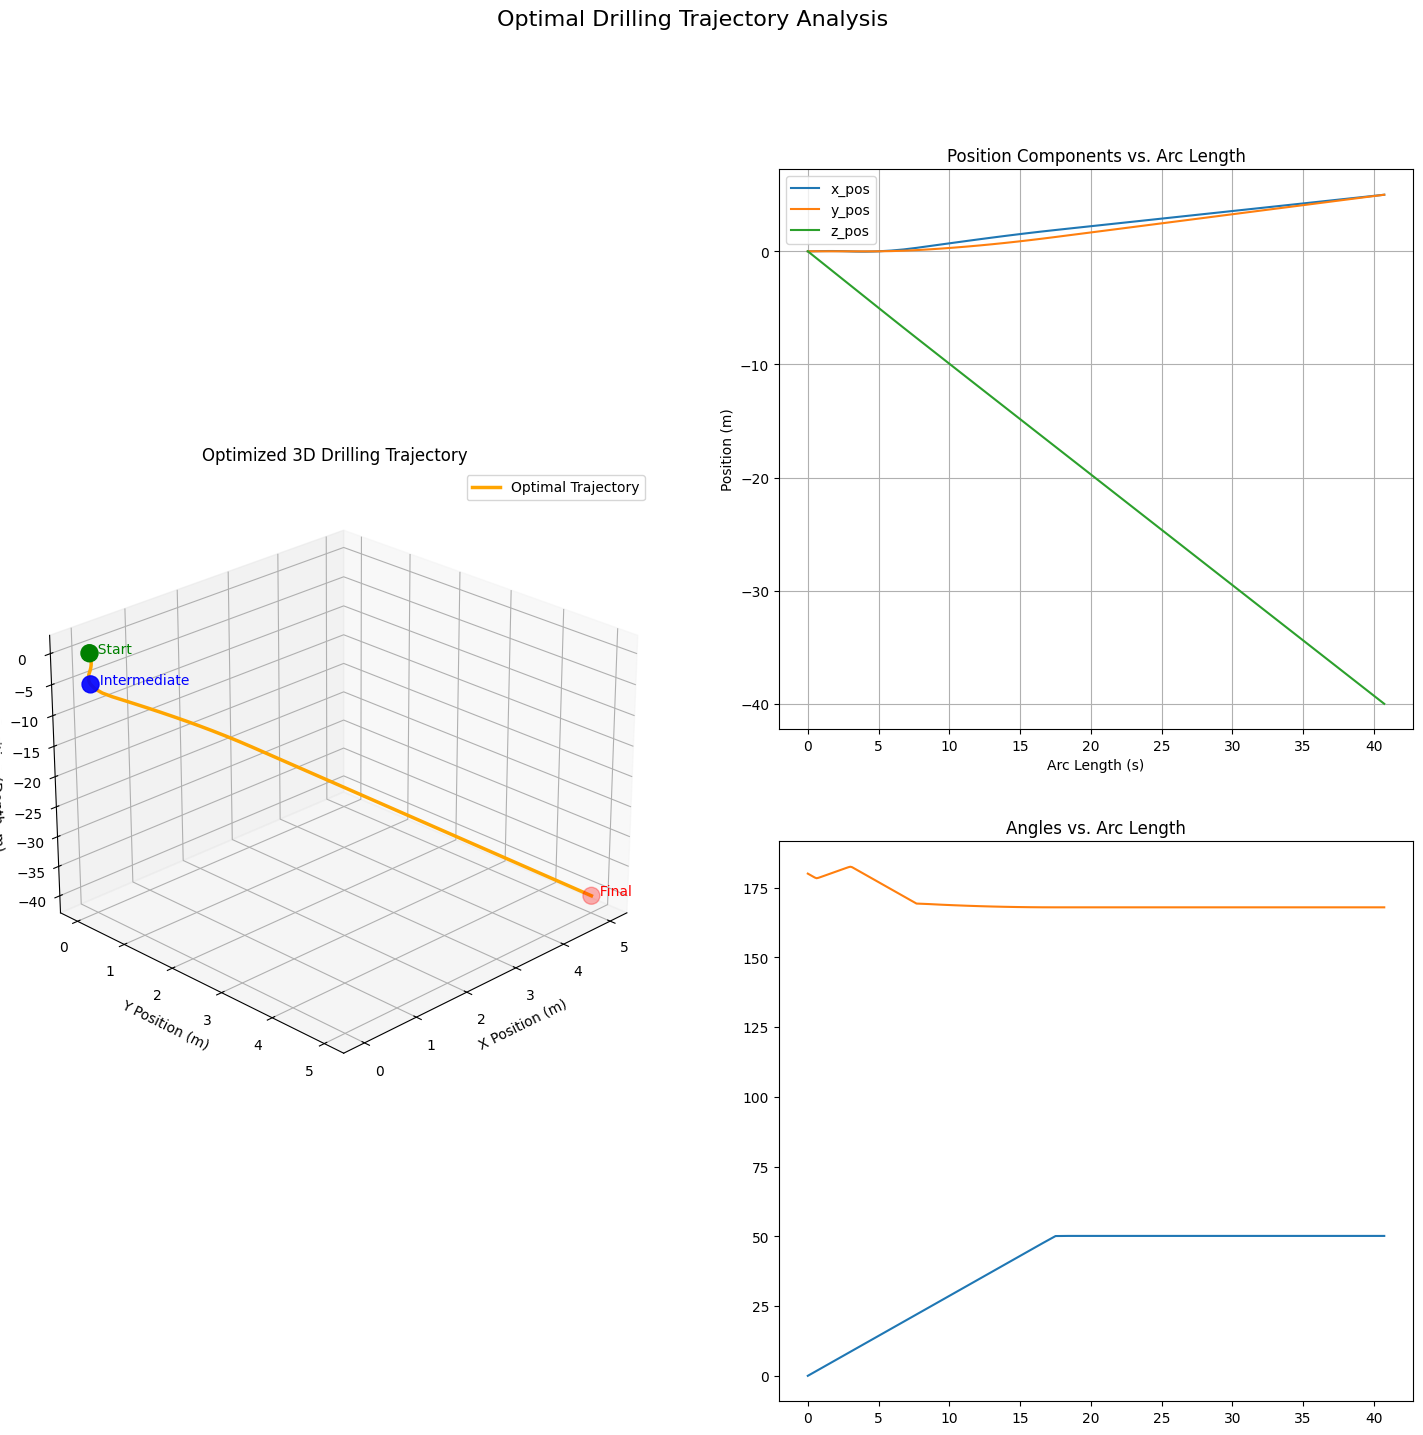

In [ ]:
# Optimal Drilling Trajectory for TUC Drillbotics
# This script uses the rockit library to find the optimal trajectory for a drill bit
# passing through three points (start, intermediate, final).
# The problem is modeled as a two-stage Optimal Control Problem (OCP) where
# the objective is to minimize the total drilling time.
# The system dynamics are parameterized by arc length 's', as detailed in the
# provided "Trajectory.pdf" and "project.ipynb" documents.

import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from rockit import Ocp, FreeTime, DirectCollocation

def create_drilling_stage(ocp):
    """
    Creates a single stage of the drilling trajectory OCP.

    This function defines the common states, controls, dynamics, and path constraints
    for any segment of the trajectory.

    Parameters
    ----------
    ocp : rockit.Ocp
        The Optimal Control Problem object.

    Returns
    -------
    stage : rockit.Stage
        The configured OCP stage.
    x_pos, y_pos, z_pos, t, azimuth, inclination : casadi.MX
        State variables.
    u_azimuth_rate_ds, u_inclination_rate_ds, inverse_rop : casadi.MX
        Control variables.
    """
    # Create a stage with a free independent variable (arc length 's')
    # An initial guess of 10 for the arc length is provided.
    stage = ocp.stage(T=FreeTime(10.0))

    # --- State Variables ---
    # Position
    x_pos = stage.state()
    y_pos = stage.state()
    z_pos = stage.state()
    # Time
    t = stage.state()
    # Angles
    azimuth = stage.state()
    inclination = stage.state()

    # --- Control Variables ---
    # Angular rates with respect to arc length 's'
    u_azimuth_rate_ds = stage.control()     # dA/ds
    u_inclination_rate_ds = stage.control() # dI/ds
    # Inverse of Rate of Penetration (ROP)
    inverse_rop = stage.control()           # dt/ds

    # --- System Dynamics (derivatives w.r.t. arc length 's') ---
    stage.set_der(x_pos, ca.sin(inclination) * ca.cos(azimuth))
    stage.set_der(y_pos, ca.sin(inclination) * ca.sin(azimuth))
    stage.set_der(z_pos, ca.cos(inclination))
    stage.set_der(azimuth, u_azimuth_rate_ds)
    stage.set_der(inclination, u_inclination_rate_ds)
    stage.set_der(t, inverse_rop)

    # --- Regularization: Penalize control effort ---
    # This term is added to the objective to prevent numerical issues (singularities)
    # when the drill is pointing straight down (sin(inclination) = 0),
    # which makes the azimuth angle ambiguous. It encourages a smoother path.
    stage.add_objective(1e-4 * stage.integral(u_azimuth_rate_ds**2 + u_inclination_rate_ds**2))

    # --- Path Constraints ---
    # Maximum Build-Up Rate (BUR) in rad/m
    max_bur = 0.05
    stage.subject_to(u_inclination_rate_ds >= -max_bur)
    stage.subject_to(u_inclination_rate_ds <= max_bur)

    stage.subject_to(u_azimuth_rate_ds >= -max_bur)
    stage.subject_to(u_azimuth_rate_ds <= max_bur)

    # Constraint to ensure the drill bit always points downwards
    # Inclination must be between 90 (pi/2) and 270 (3*pi/2) degrees.
    stage.subject_to(inclination >= ca.pi / 2)
    stage.subject_to(inclination <= 3 * ca.pi / 2)

    # Rate of Penetration (ROP) limits in m/min
    rop_max = 30.0
    rop_min = 5.0
    # Constraints are on the inverse of ROP (dt/ds)
    stage.subject_to(inverse_rop >= 1 / rop_max)
    stage.subject_to(inverse_rop <= 1 / rop_min)

    # --- Discretization Method ---
    # Using Direct Collocation with 40 nodes for higher accuracy.
    stage.method(DirectCollocation(N=40))

    return (stage, x_pos, y_pos, z_pos, t, azimuth, inclination,
            u_azimuth_rate_ds, u_inclination_rate_ds, inverse_rop)

# -------------------------------------------------------------------------
# --- Main Problem Setup ---
# -------------------------------------------------------------------------

# Initialize the Optimal Control Problem
ocp = Ocp()

# Define the target points for the trajectory to demonstrate the fix for collinear points.
start_point = [0, 0, 0]
intermediate_point = [0, 0, -5]
final_point = [5, 5, -40]

# --- Stage 1: Start Point to Intermediate Point ---
(s1, x1, y1, z1, t1, a1, i1, ua1, ui1, ir1) = create_drilling_stage(ocp)

# Set initial conditions for the entire trajectory (at t0 of stage 1)
ocp.subject_to(s1.at_t0(x1) == start_point[0])
ocp.subject_to(s1.at_t0(y1) == start_point[1])
ocp.subject_to(s1.at_t0(z1) == start_point[2])
ocp.subject_to(s1.at_t0(a1) == 0)        # Azimuth starts at 0
ocp.subject_to(s1.at_t0(i1) == ca.pi)    # Inclination is pi (pointing down)
ocp.subject_to(s1.at_t0(t1) == 0)        # Time starts at 0

# Set terminal conditions for stage 1 (the intermediate point)
ocp.subject_to(s1.at_tf(x1) == intermediate_point[0])
ocp.subject_to(s1.at_tf(y1) == intermediate_point[1])
ocp.subject_to(s1.at_tf(z1) == intermediate_point[2])


# --- Stage 2: Intermediate Point to Final Point ---
(s2, x2, y2, z2, t2, a2, i2, ua2, ui2, ir2) = create_drilling_stage(ocp)

# Impose continuity between Stage 1 and Stage 2
# The final state of stage 1 must equal the initial state of stage 2.
ocp.subject_to(s1.at_tf(x1) == s2.at_t0(x2))
ocp.subject_to(s1.at_tf(y1) == s2.at_t0(y2))
ocp.subject_to(s1.at_tf(z1) == s2.at_t0(z2))
ocp.subject_to(s1.at_tf(t1) == s2.at_t0(t2))
ocp.subject_to(s1.at_tf(a1) == s2.at_t0(a2))
ocp.subject_to(s1.at_tf(i1) == s2.at_t0(i2))

# Set terminal conditions for stage 2 (the final point)
ocp.subject_to(s2.at_tf(x2) == final_point[0])
ocp.subject_to(s2.at_tf(y2) == final_point[1])
ocp.subject_to(s2.at_tf(z2) == final_point[2])

# --- Objective Function ---
# Minimize the total time, which is the value of state 't' at the end of stage 2.
# This is a terminal (Mayer) cost, added to the final stage.
s2.add_objective(s2.at_tf(t2))

# --- Solve the OCP ---
ocp.solver('ipopt', {'ipopt.print_level': 5, 'ipopt.max_iter': 500})
sol = ocp.solve()

# -------------------------------------------------------------------------
# --- Plotting Results ---
# -------------------------------------------------------------------------

# --- Sample data from both stages ---
# Get the final arc length of stage 1 to offset the second stage's results
s1_tf_val = sol(s1).value(s1.tf)

# Stage 1 data
ts1, x1_sol = sol(s1).sample(x1, grid='integrator')
ts1, y1_sol = sol(s1).sample(y1, grid='integrator')
ts1, z1_sol = sol(s1).sample(z1, grid='integrator')
ts1, t1_sol = sol(s1).sample(t1, grid='integrator')
ts1, a1_sol = sol(s1).sample(a1, grid='integrator')
ts1, i1_sol = sol(s1).sample(i1, grid='integrator')
ts1_ctrl, ua1_sol = sol(s1).sample(ua1, grid='control')
ts1_ctrl, ui1_sol = sol(s1).sample(ui1, grid='control')
ts1_ctrl, ir1_sol = sol(s1).sample(ir1, grid='control')

# Stage 2 data
ts2, x2_sol = sol(s2).sample(x2, grid='integrator')
ts2, y2_sol = sol(s2).sample(y2, grid='integrator')
ts2, z2_sol = sol(s2).sample(z2, grid='integrator')
ts2, t2_sol = sol(s2).sample(t2, grid='integrator')
ts2, a2_sol = sol(s2).sample(a2, grid='integrator')
ts2, i2_sol = sol(s2).sample(i2, grid='integrator')
ts2_ctrl, ua2_sol = sol(s2).sample(ua2, grid='control')
ts2_ctrl, ui2_sol = sol(s2).sample(ui2, grid='control')
ts2_ctrl, ir2_sol = sol(s2).sample(ir2, grid='control')


# # --- Combine data for continuous plots ---
# s_sol = np.concatenate((ts1, ts2 + s1_tf_val))
# x_sol = np.concatenate((x1_sol, x2_sol))
# y_sol = np.concatenate((y1_sol, y2_sol))
# z_sol = np.concatenate((z1_sol, z2_sol))
# t_sol = np.concatenate((t1_sol, t2_sol))
# a_sol = np.concatenate((a1_sol, a2_sol))
# i_sol = np.concatenate((i1_sol, i2_sol))

# s_ctrl_sol = np.concatenate((ts1_ctrl, ts2_ctrl + s1_tf_val))
# ua_sol = np.concatenate((ua1_sol, ua2_sol))
# ui_sol = np.concatenate((ui1_sol, ui2_sol))
# ir_sol = np.concatenate((ir1_sol, ir2_sol))

# --- Create Plots ---
fig = plt.figure(figsize=(18, 16))
fig.suptitle('Optimal Drilling Trajectory Analysis', fontsize=16)

# 3D Trajectory Plot
ax3d = fig.add_subplot(2, 2, (1, 3), projection='3d')
ax3d.plot(x_sol, y_sol, z_sol, label='Optimal Trajectory', linewidth=2.5, color='orange')
points = np.array([start_point, intermediate_point, final_point])
ax3d.scatter(points[:,0], points[:,1], points[:,2], c=['green', 'blue', 'red'], s=150, depthshade=True)
ax3d.text(points[0,0], points[0,1], points[0,2], '  Start', color='green')
ax3d.text(points[1,0], points[1,1], points[1,2], '  Intermediate', color='blue')
ax3d.text(points[2,0], points[2,1], points[2,2], '  Final', color='red')
ax3d.set_xlabel("X Position (m)")
ax3d.set_ylabel("Y Position (m)")
ax3d.set_zlabel("Z Position (Depth, m)")
ax3d.set_title("Optimized 3D Drilling Trajectory")
ax3d.legend()
ax3d.invert_yaxis() # Invert Z-axis to show depth correctly
ax3d.view_init(elev=25, azim=-135)

# Set axis limits to be equal for a better aspect ratio
# max_range = np.array([x_sol.max()-x_sol.min(), y_sol.max()-y_sol.min(), z_sol.max()-z_sol.min()]).max() / 2.0
# mid_x = (x_sol.max()+x_sol.min()) * 0.5
# mid_y = (y_sol.max()+y_sol.min()) * 0.5
# mid_z = (z_sol.max()+z_sol.min()) * 0.5
# ax3d.set_xlim(mid_x - max_range, mid_x + max_range)
# ax3d.set_ylim(mid_y - max_range, mid_y + max_range)
# ax3d.set_zlim(mid_z - max_range, mid_z + max_range)


# Position vs. Arc Length
ax1 = fig.add_subplot(2, 2, 2)
ax1.plot(s_sol, x_sol, label='x_pos')
ax1.plot(s_sol, y_sol, label='y_pos')
ax1.plot(s_sol, z_sol, label='z_pos')
ax1.set_title("Position Components vs. Arc Length")
ax1.set_xlabel("Arc Length (s)")
ax1.set_ylabel("Position (m)")
ax1.legend()
ax1.grid(True)

# Angles vs. Arc Length
ax2 = fig.add_subplot(2, 2, 4)
ax2.plot(s_sol, np.rad2deg(a_sol), label='Azimuth')
ax2.plot(s_sol, np.rad2deg(i_sol), label='Inclination')
ax2.set_title("Angles vs. Arc Length")